In [1]:
from functional import *

2024-10-19 14:37:08.408009: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-19 14:37:08.418189: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-19 14:37:08.421575: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-19 14:37:08.430058: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-19 14:37:09.055779: W tensorflow/compiler/tf2

In [2]:
with open(os.path.join(Path().cwd(),'parameters.json'),'r+') as f:
          parameter=json.loads(f.read())
          start_date=parameter['start_date']
          test_date=parameter['test_date']
          end_date=parameter['end_date']
df=pd.read_csv('SPX_1d.csv',index_col=0)
df_train=df.loc[start_date:test_date]
df_test=df.loc[test_date:end_date]

In [3]:
class ql_agent():
    def __init__(self,env,qtable_height=40,qtable_width=10,learning_rate=0.1,discount_value=0.9,epochs=1000,epsilon=0.99,epsilon_decay=0.99,overflow=0.05):
        self.learning_rate=learning_rate
        self.discount_value=discount_value
        self.epochs=epochs
        self.epsilon=epsilon
        self.epsilon_decay=epsilon_decay
        self.env=env
        self.overflow=overflow
        self.qtable_height=qtable_height
        self.qtable_width=qtable_width
    
    def create_qtable(self):
        self.qtable_size=(self.qtable_height,self.qtable_width)
        self.qtable_segment_size=(self.env.observation_max*(1+self.overflow)-self.env.observation_min*(1-self.overflow))/np.array(self.qtable_size)
        self.qtable=np.random.uniform(low=-2,high=0,size=self.qtable_size+(3,))

    def convert_state(self,current_state):
        return tuple(((current_state-self.env.observation_min*(1-self.overflow))/self.qtable_segment_size).astype(int))
    
    def update_qtable(self,current_state,new_state,reward,action):
        current_q_value=self.qtable[current_state+(action,)]

        new_state=new_state[0]
        new_state=self.convert_state(new_state)
        new_q_value=(1-self.learning_rate) * current_q_value+self.learning_rate*reward
        self.qtable[current_state + (action,)] = new_q_value
    
    def decide(self,current_state):
        return np.argmax(self.qtable[current_state])

    def train(self):
        self.create_qtable()
        self.best_portforlio_value=-9999999
        self.action_list=None
        self.portforlio_history=None

        for epoch in range(self.epochs):

            print(f'Epoch :{epoch}')
            current_state,_=self.env.reset()
            current_state=current_state[0]
            current_state=self.convert_state(current_state)

            epoch_portforlio_value=None
            epoch_actions_list=[]
            epoch_portforlio_history=[]

            while True:
                if np.random.uniform(0,1,size=1)[0]<self.epsilon:
                    action=np.random.randint(0,2)
                else:
                    action=self.decide(current_state)
                new_state,reward,terminate,truncate,_=self.env.step(action)
                self.update_qtable(current_state,new_state,reward,action)

                current_state=new_state
                current_state=current_state[0]
                current_state=self.convert_state(current_state)

                epoch_portforlio_history.append(self.env.total)
                epoch_actions_list.append(action)

                if terminate:
                    epoch_portforlio_value=self.env.total
                    if self.best_portforlio_value<epoch_portforlio_value:
                        self.best_portforlio_value=epoch_portforlio_value
                        self.action_list=epoch_actions_list
                        self.portforlio_history=epoch_portforlio_history
                    break
            self.epsilon*=self.epsilon_decay
            print(f'Portforlio value :{round(epoch_portforlio_value,3)},number of actions :{len(epoch_actions_list)}')

In [4]:
env=trading_env(df_train,1)
agen=ql_agent(env,epochs=500,qtable_height=300,qtable_width=100)

/home/golderalex2/Downloads/statistic/python/reinforce_trading/test/environment.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Diff_pct']=self.df['Close'].pct_change(1).fillna(0)*100


In [5]:
agen.train()

Epoch :0
Portforlio value :133.368,number of actions :1195
Epoch :1
Portforlio value :132.652,number of actions :1195
Epoch :2
Portforlio value :136.961,number of actions :1195
Epoch :3
Portforlio value :132.906,number of actions :1195
Epoch :4
Portforlio value :129.845,number of actions :1195
Epoch :5
Portforlio value :125.719,number of actions :1195
Epoch :6
Portforlio value :130.037,number of actions :1195
Epoch :7
Portforlio value :128.775,number of actions :1195
Epoch :8
Portforlio value :131.65,number of actions :1195
Epoch :9
Portforlio value :129.837,number of actions :1195
Epoch :10
Portforlio value :133.524,number of actions :1195
Epoch :11
Portforlio value :120.326,number of actions :1195
Epoch :12
Portforlio value :132.89,number of actions :1195
Epoch :13
Portforlio value :118.343,number of actions :1195
Epoch :14
Portforlio value :135.328,number of actions :1195
Epoch :15
Portforlio value :129.031,number of actions :1195
Epoch :16
Portforlio value :128.203,number of action

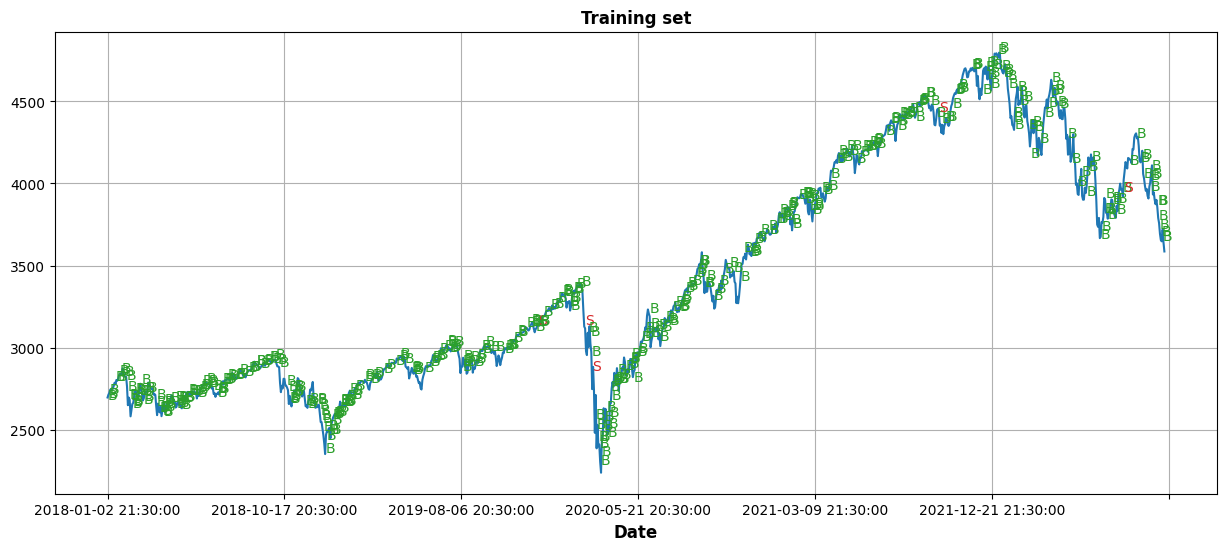

In [6]:
visualize(df_train,agen.action_list,'Training set')

In [7]:
portforlio_history=[]
action_list=[]

env=trading_env(df_test,1)
current_state,info=env.reset()
current_state=current_state[0]
current_state=agen.convert_state(current_state)

while True:
    action=agen.decide(current_state)
    new_state,reward,terminate,truncate,_=env.step(action)

    current_state=new_state
    current_state=current_state[0]
    current_state=agen.convert_state(current_state)

    portforlio_history.append(env.total)
    action_list.append(action)

    if terminate:
        break

/home/golderalex2/Downloads/statistic/python/reinforce_trading/test/environment.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Diff_pct']=self.df['Close'].pct_change(1).fillna(0)*100


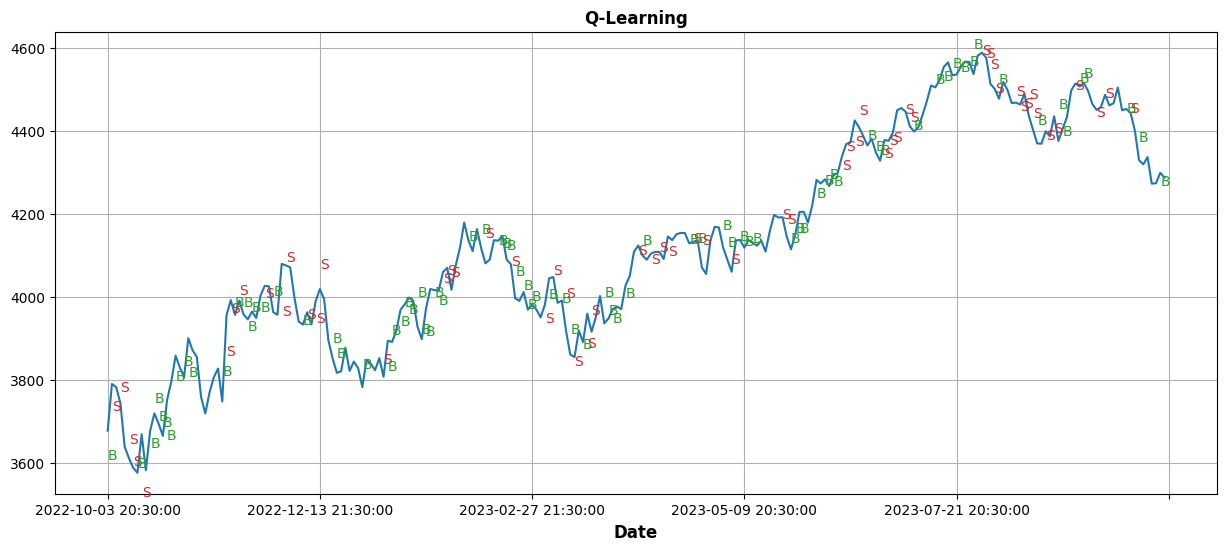

In [8]:
visualize(df_test,action_list,'Q-Learning')

In [9]:
evaluate(portforlio_history)

Max drawdown     7.416729
PnL             35.397423
ROI             35.397423
dtype: float64